In [1]:
# importing needed modules
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from service_modules.target_transform_module import target_transform_fun1
from service_modules.target_untransform_module import target_untransform_fun
import warnings
warnings.filterwarnings("ignore")

from math import sqrt, floor
from sklearn.metrics import mean_squared_error
from service_modules.ancillary_functions import mean_absolute_percentage_error

In [2]:
# reading in a Miles series
Miles = pd.read_csv('Miles.csv', index_col = None)
Miles = Miles.set_index('index')
Miles.index = pd.to_datetime(Miles.index)
Miles = pd.Series(Miles.iloc[:,0])

In [3]:
# showing representative data
Miles

index
2018-03-25    102185.0
2018-04-01    117641.0
2018-04-08    128156.0
2018-04-15    113316.0
2018-04-22    119489.0
                ...   
2020-12-06    141150.0
2020-12-13    135763.0
2020-12-20     90632.0
2020-12-27     83029.0
2021-01-03    146781.0
Name: C00170, Length: 146, dtype: float64

In [4]:
# creating training and test sets
test_length = 39
test_start = len(Miles) - test_length
train = Miles[:test_start]
test = Miles[-test_length:]

In [5]:
# running stationary and box-cox transformations
train_trans, helper2 = target_transform_fun1(train, 'yes', 'no')
train_trans = train_trans.dropna()

In [6]:
# showing representative data
train_trans

index
2018-04-01    9.555485e+08
2018-04-08    7.228848e+08
2018-04-15   -1.003135e+09
2018-04-22    4.030368e+08
2018-04-29    1.229703e+09
                  ...     
2020-03-08    2.854750e+08
2020-03-15   -8.432703e+08
2020-03-22   -1.211915e+08
2020-03-29   -8.549007e+08
2020-04-05    9.820239e+08
Name: C00170, Length: 106, dtype: float64

In [7]:
# instantiating model object and training model
model = SARIMAX(train_trans,
                order=(1,0,3),
                seasonal_order=(1,0,1,52),
                enforce_stationarity=False,
                enforce_invertibility=True)
model_fit = model.fit(disp=False, 
                      dynamic=True,
                      method = 'powell')

# producing point forecasts and prediction intervals
forecast_obj = model_fit.get_forecast(steps = 39)
forecast = forecast_obj.predicted_mean
ci_95 = forecast_obj.conf_int(alpha=.05)

In [8]:
# combining data; back transforming the results; reformatting the plot data
plot_A = pd.concat([train,test,forecast,ci_95], axis=1)
plot_B = plot_A.iloc[:,:2]
plot_C = plot_A.iloc[-test_length:,2:]

run1 = target_untransform_fun(plot_C.iloc[:,0], helper2)
run2 = target_untransform_fun(plot_C.iloc[:,1], helper2)
run3 = target_untransform_fun(plot_C.iloc[:,2], helper2)

run1.index = test.index
run2.index = test.index
run3.index = test.index

plot_D1 = pd.concat([plot_B,run1,run2,run3], axis=1)
plot_D1.columns.values[[0]] = ['Train']
plot_D1.columns.values[[1]] = ['Test']
plot_D1.columns.values[[2]] = ['Forecast']
plot_D1.columns.values[[3]] = ['Lower']
plot_D1.columns.values[[4]] = ['Upper']

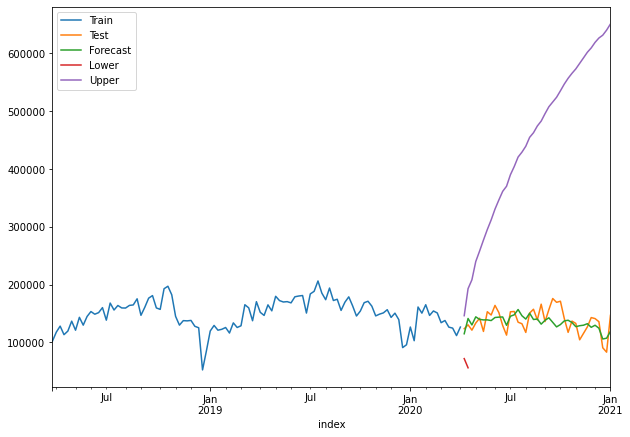

In [9]:
plot_D1.plot(figsize = (10,7));

In [10]:
mape_err = mean_absolute_percentage_error(run1,test)
print(mape_err)
rmse_err = sqrt(mean_squared_error(run1,test))
print(rmse_err)

11.59728813829896
18743.00568284249


In [11]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               C00170   No. Observations:                  106
Model:             SARIMAX(1, 0, 3)x(1, 0, [1], 52)   Log Likelihood               -1114.634
Date:                              Wed, 03 Nov 2021   AIC                           2243.268
Time:                                      17:25:43   BIC                           2256.652
Sample:                                  04-01-2018   HQIC                          2248.365
                                       - 04-05-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2451      0.292     -0.840      0.401      -0.817       0.327
ma.L1         -0.1845      0.247     -0.747      0.455      -0.668       0.299
ma.L2          0.1077      0.166      0.649      0.517      -0.218       0.433
ma.L3         -0.4579      0.129     -3.550      0.000      -0.711      -0.205
ar.S.L52       0.3668      2.146      0.171      0.864      -3.839       4.573
ma.S.L52       0.0380      2.199      0.017      0.986      -4.272       4.348
sigma2      1.348e+18        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.95   Prob(JB):                         0.73
Heteroskedasticity (H):               1.56   Skew:                             0.25
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.51e+51. Standard errors may be unstable.
"""